In [1]:
import seaborn as sns
import folium
import folium.plugins as folium_plugins
from geopandas import GeoSeries, GeoDataFrame
import geopandas as gpd
import pandas as pd
from os.path import exists


from utils.downloads import (
    Censo,
    Nivel,
    download_malha,
    download_dados,
)
from utils.geosampa_client import get_client
from utils.geo import calc_similarity

In [2]:
sns.set_theme(rc={'figure.figsize':(11.7,8.27)})

# Carregando os dados necessários

Para facilitar o desenvolvimento posterior, vamos concentrar os downloads e carregamentos iniciais nesta seção.

## Setores censitários de 2022

In [3]:
%%time
setores22 = download_malha(Censo.CENSO_2022, Nivel.SETORES)
setores22 = setores22[setores22['CD_MUN'] == '3550308']
setores22 = setores22.to_crs(epsg=31983)
setores22.sample(3)

INFO:root:Carregando a malha de setores do censo de 2022.
INFO:root:O arquivo data/cache/setores/2022/SP_Malha_Preliminar_2022.zip já foi baixado anteriormente. Usando cache local.


CPU times: user 1min 6s, sys: 1.13 s, total: 1min 7s
Wall time: 1min 13s


,CD_SETOR,AREA_KM2,CD_REGIAO,NM_REGIAO,CD_UF,NM_UF,CD_MUN,NM_MUN,CD_DIST,NM_DIST,...,CD_CONCURB,NM_CONCURB,v0001,v0002,v0003,v0004,v0005,v0006,v0007,geometry
89119,355030881000019P,0.053446,3,Sudeste,35,São Paulo,3550308,São Paulo,355030881,Tremembé,...,3550308,São Paulo/SP,834,367,366,1,2.865248,28.368794,282,"POLYGON ((337123.302 7404737.335, 337127.361 7..."
86894,355030872000128P,0.082581,3,Sudeste,35,São Paulo,3550308,São Paulo,355030872,São Lucas,...,3550308,São Paulo/SP,280,125,125,0,2.522523,3.603604,111,"POLYGON ((341193.605 7391295.094, 341221.720 7..."
80058,355030846000634P,0.005243,3,Sudeste,35,São Paulo,3550308,São Paulo,355030846,Jardim São Luís,...,3550308,São Paulo/SP,205,76,76,0,3.203125,23.437500,64,"POLYGON ((320812.482 7382140.206, 320842.428 7..."


## Setores censitários de 2010

In [4]:
setores10 = download_malha(Censo.CENSO_2010, Nivel.SETORES)
setores10 = setores10[setores10['CD_GEOCODM'] == '3550308']
setores10 = setores10.to_crs(epsg=31983)
setores10.sample(3)

INFO:root:Carregando a malha de setores do censo de 2010.
INFO:root:O arquivo data/cache/setores/2010/sp_setores_censitarios.zip já foi baixado anteriormente. Usando cache local.


,ID,CD_GEOCODI,TIPO,CD_GEOCODS,NM_SUBDIST,CD_GEOCODD,NM_DISTRIT,CD_GEOCODM,NM_MUNICIP,NM_MICRO,NM_MESO,CD_GEOCODB,NM_BAIRRO,ID1,geometry
62350,127857.0,355030896000213,URBANO,35503089600,None,355030896,LAJEADO,3550308,SÃO PAULO,SÃO PAULO,METROPOLITANA DE SÃO PAULO,None,None,62351,"POLYGON ((354981.293 7396945.182, 355017.771 7..."
62221,127728.0,355030896000084,URBANO,35503089600,None,355030896,LAJEADO,3550308,SÃO PAULO,SÃO PAULO,METROPOLITANA DE SÃO PAULO,None,None,62222,"POLYGON ((357292.785 7395898.134, 357280.977 7..."
51898,117466.0,355030843000057,URBANO,35503084300,None,355030843,JARDIM ÂNGELA,3550308,SÃO PAULO,SÃO PAULO,METROPOLITANA DE SÃO PAULO,None,None,51899,"POLYGON ((319668.904 7376119.803, 319783.251 7..."


Adicionalmente, precisamos carregar os dados de população e domicílios do censo de 2010, que não vêm junto com a geometria.

In [5]:
dados10_pop = download_dados(Censo.CENSO_2010, Nivel.SETORES, arquivo='Domicilio02_SP1.xls')
dados10_pop.head()

INFO:root:Carregando os dados de setores do censo de 2010.
INFO:root:O arquivo data/cache/setores/2010/SP_Capital_20231030.zip já foi baixado anteriormente. Usando cache local.


,Cod_setor,Situacao_setor,V001,V002,V003,V004,V005,V006,V007,V008,...,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132
0,355030801000001,1,806,800,623,66,28,399,27,360,...,1,0,0,425,425,0,0,415,10,0
1,355030801000002,1,913,913,891,22,0,567,36,261,...,0,0,0,495,495,0,0,421,74,0
2,355030801000003,1,625,625,595,4,18,462,5,151,...,0,0,0,329,318,11,0,309,9,0
3,355030801000004,1,572,572,496,11,65,229,8,286,...,0,0,0,296,296,0,0,274,12,10
4,355030801000005,1,754,754,716,3,30,340,15,354,...,0,0,0,399,399,0,0,162,210,27


In [6]:
dados10_dom = download_dados(Censo.CENSO_2010, Nivel.SETORES, arquivo='Domicilio01_SP1.XLS')
dados10_dom.head()

INFO:root:Carregando os dados de setores do censo de 2010.
INFO:root:O arquivo data/cache/setores/2010/SP_Capital_20231030.zip já foi baixado anteriormente. Usando cache local.


,Cod_setor,Situacao_setor,V001,V002,V003,V004,V005,V006,V007,V008,...,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241
0,355030801000001,1,268,266,203,20,11,136,7,116,...,0,0,1,1,0,0,0,0,0,0
1,355030801000002,1,306,306,298,8,0,194,10,85,...,0,0,0,0,0,0,0,0,0,0
2,355030801000003,1,189,189,177,1,7,135,1,50,...,0,0,0,0,0,0,0,0,0,0
3,355030801000004,1,181,181,154,4,23,76,2,87,...,0,0,0,0,0,0,0,0,0,0
4,355030801000005,1,240,240,226,1,12,105,4,112,...,0,0,0,0,0,0,0,0,0,0


## Setores censitários de 2000

In [7]:
setores00 = download_malha(Censo.CENSO_2000, Nivel.SETORES)
setores00 = setores00[setores00['ID_'].str.startswith('3550308')]
setores00 = setores00.to_crs(epsg=31983)
setores00.sample(3)

INFO:root:Carregando a malha de setores do censo de 2000.
INFO:root:O arquivo data/cache/setores/2000/3550308.zip já foi baixado anteriormente. Usando cache local.


,ID_,NAME1_,NAME2_,PARTS_,POINTS_,LENGTH_,AREA_,geometry
12456,355030836000127,None,None,3,47,0.777934,0.028318,"POLYGON ((359216.000 17399060.000, 359223.000 ..."
430,355030823000214,None,None,1,31,1.041543,0.032669,"POLYGON ((325273.000 17371110.000, 325281.000 ..."
2970,355030832000089,None,None,1,5,0.291044,0.005293,"POLYGON ((329588.000 17388696.000, 329678.000 ..."


Adicionalmente, precisamos carregar os dados de população e domicílios do censo de 2010, que não vêm junto com a geometria.

In [8]:
dados00_pop = download_dados(Censo.CENSO_2000, Nivel.SETORES, arquivo='Morador_SP1.XLS')
dados00_pop.head()

INFO:root:Carregando os dados de setores do censo de 2000.
INFO:root:O arquivo data/cache/setores/2000/Agregado_de_setores_2000_SP_RM.zip já foi baixado anteriormente. Usando cache local.


WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero


,Cod_setor,Situacao,Tipo_do_setor,V0237,V0238,V0239,V0240,V0241,V0242,V0243,...,V0392,V0393,V0394,V0395,V0396,V0397,V0398,V0399,V0400,V0401
0,350390105000001,1,0,471,424,424,0,47,419.0,0.0,...,0.0,1.0,229.0,229.0,0.0,0.0,0.0,0.0,0.0,0.0
1,350390105000002,1,0,590,590,589,1,0,589.0,0.0,...,0.0,48.0,299.0,299.0,0.0,0.0,0.0,0.0,0.0,0.0
2,350390105000003,1,0,485,485,479,6,0,479.0,0.0,...,0.0,0.0,239.0,237.0,2.0,0.0,0.0,0.0,0.0,0.0
3,350390105000004,1,0,654,654,654,0,0,653.0,0.0,...,0.0,2.0,350.0,347.0,3.0,0.0,0.0,0.0,0.0,0.0
4,350390105000005,1,0,572,572,572,0,0,554.0,13.0,...,0.0,1.0,307.0,307.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
dados00_dom = download_dados(Censo.CENSO_2000, Nivel.SETORES, arquivo='Domicilio_SP1.XLS')
dados00_dom.head()

INFO:root:Carregando os dados de setores do censo de 2000.
INFO:root:O arquivo data/cache/setores/2000/Agregado_de_setores_2000_SP_RM.zip já foi baixado anteriormente. Usando cache local.


WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero


,Cod_setor,Situacao,Tipo_do_setor,V0001,V0002,V0003,V0004,V0005,V0006,V0007,...,V0227,V0228,V0229,V0230,V0231,V0232,V0233,V0234,V0235,V0236
0,350390105000001,1,0,181,134,134,0,47,132.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,350390105000002,1,0,150,150,149,1,0,149.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,350390105000003,1,0,132,132,131,1,0,131.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,350390105000004,1,0,170,170,170,0,0,169.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,350390105000005,1,0,181,181,181,0,0,174.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Quadras viárias

In [10]:
quadra_fiscal_path = 'data/quadra_viaria_editada.parquet'
if exists(quadra_fiscal_path):
    gdf_quadras = gpd.read_parquet(quadra_fiscal_path)
else:
    raw_features = gs_client.get_feature('quadra_viaria_editada')
    gdf_quadras = GeoDataFrame.from_features(raw_features['features'])
    gdf_quadras = gdf_quadras.set_crs(raw_features['crs'].get('properties').get('name'))
    gdf_quadras = gdf_quadras.to_crs(epsg=31983)
    gdf_quadras.to_parquet(quadra_fiscal_path)
gdf_quadras

,geometry,cd_identificador_quadra_viaria_editada,cd_identificador_quadra_viaria_editada_original,tx_tipo_quadra_viaria,tx_escala,tx_ano_referencia,qt_area_metro,sg_fonte_original
0,"POLYGON ((338344.482 7407584.661, 338344.543 7...",1,52943,Quadra,1:1.000,2004,7650,SMUL/GEOINFO
1,"POLYGON ((327186.316 7377154.793, 327188.886 7...",2,4,Praca_Canteiro,1:1.000,2004,11,SMUL/GEOINFO
2,"POLYGON ((324545.386 7402131.104, 324544.170 7...",3,5,Praca_Canteiro,1:1.000,2004,6,SMUL/GEOINFO
3,"POLYGON ((326273.589 7399282.971, 326273.013 7...",4,6,Praca_Canteiro,1:1.000,2004,109,SMUL/GEOINFO
4,"POLYGON ((322149.447 7392535.031, 322154.771 7...",5,7,Praca_Canteiro,1:1.000,2004,12,SMUL/GEOINFO
...,...,...,...,...,...,...,...,...
64779,"POLYGON ((325071.550 7397335.276, 325073.371 7...",64780,0,Praca_Canteiro,1:1.000,2017,0,SMUL/GEOINFO
64780,"POLYGON ((325064.631 7397341.102, 325065.814 7...",64781,0,Praca_Canteiro,1:1.000,2017,0,SMUL/GEOINFO
64781,"POLYGON ((325102.327 7397333.002, 325089.121 7...",64782,58914,Praca_Canteiro,1:1.000,2004,25982,SMUL/GEOINFO
64782,"POLYGON ((325081.631 7397226.147, 325087.148 7...",64783,0,Praca_Canteiro,1:1.000,2017,0,SMUL/GEOINFO


In [11]:
gdf_quadras.head()

,geometry,cd_identificador_quadra_viaria_editada,cd_identificador_quadra_viaria_editada_original,tx_tipo_quadra_viaria,tx_escala,tx_ano_referencia,qt_area_metro,sg_fonte_original
0,"POLYGON ((338344.482 7407584.661, 338344.543 7...",1,52943,Quadra,1:1.000,2004,7650,SMUL/GEOINFO
1,"POLYGON ((327186.316 7377154.793, 327188.886 7...",2,4,Praca_Canteiro,1:1.000,2004,11,SMUL/GEOINFO
2,"POLYGON ((324545.386 7402131.104, 324544.170 7...",3,5,Praca_Canteiro,1:1.000,2004,6,SMUL/GEOINFO
3,"POLYGON ((326273.589 7399282.971, 326273.013 7...",4,6,Praca_Canteiro,1:1.000,2004,109,SMUL/GEOINFO
4,"POLYGON ((322149.447 7392535.031, 322154.771 7...",5,7,Praca_Canteiro,1:1.000,2004,12,SMUL/GEOINFO


Para garantir, vamos conferir o crs e garantir todos os datasets utilizam o mesmo sistema.

In [12]:
setores00.crs

<Projected CRS: EPSG:31983>
Name: SIRGAS 2000 / UTM zone 23S
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Brazil - between 48°W and 42°W, northern and southern hemispheres, onshore and offshore.
- bounds: (-48.0, -33.5, -42.0, 5.13)
Coordinate Operation:
- name: UTM zone 23S
- method: Transverse Mercator
Datum: Sistema de Referencia Geocentrico para las AmericaS 2000
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [13]:
setores10.crs

<Projected CRS: EPSG:31983>
Name: SIRGAS 2000 / UTM zone 23S
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Brazil - between 48°W and 42°W, northern and southern hemispheres, onshore and offshore.
- bounds: (-48.0, -33.5, -42.0, 5.13)
Coordinate Operation:
- name: UTM zone 23S
- method: Transverse Mercator
Datum: Sistema de Referencia Geocentrico para las AmericaS 2000
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [14]:
setores22.crs

<Projected CRS: EPSG:31983>
Name: SIRGAS 2000 / UTM zone 23S
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Brazil - between 48°W and 42°W, northern and southern hemispheres, onshore and offshore.
- bounds: (-48.0, -33.5, -42.0, 5.13)
Coordinate Operation:
- name: UTM zone 23S
- method: Transverse Mercator
Datum: Sistema de Referencia Geocentrico para las AmericaS 2000
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [15]:
gdf_quadras.crs

<Projected CRS: EPSG:31983>
Name: SIRGAS 2000 / UTM zone 23S
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Brazil - between 48°W and 42°W, northern and southern hemispheres, onshore and offshore.
- bounds: (-48.0, -33.5, -42.0, 5.13)
Coordinate Operation:
- name: UTM zone 23S
- method: Transverse Mercator
Datum: Sistema de Referencia Geocentrico para las AmericaS 2000
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

# Preparando os dados

## Aplicando buffers negativos nos setores censitários

In [16]:
setores22_debuff = setores22.copy()
setores22_debuff['geometry'] = setores22_debuff.buffer(-2)

In [17]:
setores10_debuff = setores10.copy()
setores10_debuff['geometry'] = setores10_debuff.buffer(-2)

## Removendo quadras não habitadas

In [18]:
gdf_quadras['tx_tipo_quadra_viaria'].unique()

array(['Quadra', 'Praca_Canteiro', 'CET', 'Borda', 'Ilha'], dtype=object)

In [19]:
quadras_viarias = gdf_quadras.query('tx_tipo_quadra_viaria == "Quadra"').copy()
quadras_viarias.head()

,geometry,cd_identificador_quadra_viaria_editada,cd_identificador_quadra_viaria_editada_original,tx_tipo_quadra_viaria,tx_escala,tx_ano_referencia,qt_area_metro,sg_fonte_original
0,"POLYGON ((338344.482 7407584.661, 338344.543 7...",1,52943,Quadra,1:1.000,2004,7650,SMUL/GEOINFO
20,"POLYGON ((320433.366 7395346.357, 320474.980 7...",21,32,Quadra,1:1.000,2004,5372,SMUL/GEOINFO
23,"POLYGON ((320527.185 7395368.353, 320526.962 7...",24,35,Quadra,1:1.000,2004,5476,SMUL/GEOINFO
25,"POLYGON ((320533.150 7395370.806, 320576.085 7...",26,37,Quadra,1:1.000,2004,5941,SMUL/GEOINFO
27,"POLYGON ((320631.706 7395394.505, 320636.887 7...",28,39,Quadra,1:1.000,2004,7033,SMUL/GEOINFO


# Avaliando as similaridades com base nas quadras viárias

## Visualizando uma amostra aleatória

In [20]:
calc_similarity(quadras_viarias.sample(1), setores22_debuff, left_key_col='cd_identificador_quadra_viaria_editada', right_key_col='CD_SETOR')

,cd_identificador_quadra_viaria_editada,CD_SETOR,geometry,inter_area,inter_perc
69151,12963,355030817000281P,"MULTIPOLYGON (((321686.681 7386567.106, 321658...",4.344612,0.000077
69338,12963,355030817000481P,"POLYGON ((321749.453 7386512.305, 321760.792 7...",6219.347455,0.109878
89880,12963,355030883000231P,"POLYGON ((321754.024 7386511.975, 321814.730 7...",28267.293577,0.499403
89881,12963,355030883000232P,"POLYGON ((321751.014 7386731.679, 321745.160 7...",9241.335356,0.163268
89977,12963,355030883000333P,"POLYGON ((321673.780 7386683.446, 321673.967 7...",5628.723600,0.099444
89978,12963,355030883000334P,"POLYGON ((321708.660 7386608.839, 321766.437 7...",7241.158701,0.127931


In [21]:
calc_similarity(setores22_debuff.sample(1), quadras_viarias, left_key_col='CD_SETOR', right_key_col='cd_identificador_quadra_viaria_editada')

,CD_SETOR,cd_identificador_quadra_viaria_editada,geometry,inter_area,inter_perc
19984,355030831000149P,19985,"POLYGON ((355109.235 7394820.727, 355128.227 7...",32321.193621,1.0


In [22]:
m = setores22[setores22['CD_SETOR'].isin(['355030840000064P'])].explore(
    name='Setores (2022)',  # name of the layer in the map
    color='royalblue',
    style_kwds={'fill': False},
)
m = gdf_quadras[gdf_quadras['cd_identificador_quadra_viaria_editada'].isin([50501, 50590, 51697])].explore(
    m=m,
    name='Quadras viárias',  # name of the layer in the map
    color='purple',
)

folium.LayerControl().add_to(m)  # use folium to add layer control

m

## Calculando a composição das quadras

In [23]:
%%time
quadras_composition_22_path = 'data/11_quadras_composition_22.parquet'
if exists(quadras_composition_22_path):
    comp_df = gpd.read_parquet(quadras_composition_22_path)
else:
    comp_df = calc_similarity(quadras_viarias, setores22_debuff, left_key_col='cd_identificador_quadra_viaria_editada', right_key_col='CD_SETOR')

CPU times: user 340 ms, sys: 132 ms, total: 472 ms
Wall time: 1.14 s


In [24]:
comp_df

,cd_identificador_quadra_viaria_editada,CD_SETOR,geometry,inter_area,inter_perc
89339,1,355030881000338P,"POLYGON ((338344.543 7407586.495, 338344.890 7...",7649.167652,1.000000
77548,21,355030841000092P,"POLYGON ((320474.980 7395356.768, 320476.196 7...",5372.137667,1.000000
77548,24,355030841000092P,"POLYGON ((320526.962 7395367.967, 320526.872 7...",5476.762509,1.000000
77548,26,355030841000092P,"POLYGON ((320576.085 7395380.678, 320578.024 7...",5941.258822,1.000000
77548,28,355030841000092P,"POLYGON ((320636.887 7395372.752, 320652.850 7...",7033.083482,1.000000
...,...,...,...,...,...
75135,64784,355030833000353P,"MULTIPOLYGON (((355011.251 7389932.753, 355011...",62095.383621,0.058578
75136,64784,355030833000354P,"MULTIPOLYGON (((355261.512 7389451.321, 355254...",18509.597432,0.017461
75137,64784,355030833000355P,"MULTIPOLYGON (((355234.321 7389581.381, 355235...",14208.916653,0.013404
75149,64784,355030833000367P,"POLYGON ((355941.048 7387947.593, 355941.109 7...",18267.972041,0.017233


Primeiro, vamos garantir que todas as interseções sejam compostas apenas por polígonos

In [25]:
comp_df['geometry'].type.value_counts()

Polygon         68191
MultiPolygon     6205
Name: count, dtype: int64

Como não existem GeometryCollections, seguimos com as análises.

In [26]:
comp_df.to_parquet(quadras_composition_22_path)

## Calculando a similaridade das quadras com os setores de 2022

In [27]:
%%time
quadras_similarity_22_path = 'data/11_quadras_similarity_22.parquet'
if exists(quadras_similarity_22_path):
    sim_22 = gpd.read_parquet(quadras_similarity_22_path)
else:
    sim_22 = calc_similarity(setores22_debuff, quadras_viarias, left_key_col='CD_SETOR', right_key_col='cd_identificador_quadra_viaria_editada')

CPU times: user 314 ms, sys: 186 ms, total: 500 ms
Wall time: 1.49 s


In [28]:
sim_22

,CD_SETOR,cd_identificador_quadra_viaria_editada,geometry,inter_area,inter_perc
38479,355030801000001P,38480,"POLYGON ((339624.362 7392759.970, 339655.406 7...",2423.419273,0.041683
38548,355030801000001P,38549,"POLYGON ((339527.710 7392818.881, 339528.951 7...",11017.294210,0.189500
39168,355030801000001P,39169,"POLYGON ((339719.044 7392694.660, 339743.021 7...",11605.305329,0.199614
39181,355030801000001P,39182,"POLYGON ((339605.452 7392737.598, 339605.898 7...",14457.293542,0.248668
55865,355030801000001P,55866,"POLYGON ((339689.654 7392784.177, 339664.214 7...",18635.535290,0.320535
...,...,...,...,...,...
20898,355030896000338P,20899,"POLYGON ((355571.342 7397652.973, 355572.047 7...",3397.302028,0.129597
21765,355030896000338P,21766,"POLYGON ((355569.586 7397689.532, 355569.364 7...",10270.063319,0.391773
20537,355030896000339P,20538,"POLYGON ((355804.621 7397538.952, 355799.039 7...",957.917148,0.129406
20898,355030896000339P,20899,"POLYGON ((355570.911 7397640.723, 355571.163 7...",982.700260,0.132754


### Teste de refatoração usando overlay

In [42]:
%%time
sim_22_overlay = gpd.overlay(
    setores22_debuff[['CD_SETOR', 'geometry']],
    quadras_viarias[['cd_identificador_quadra_viaria_editada', 'geometry']],
    how='intersection',
    keep_geom_type=True
)
sim_22_overlay

CPU times: user 8.31 s, sys: 59.8 ms, total: 8.37 s
Wall time: 8.38 s


,CD_SETOR,cd_identificador_quadra_viaria_editada,geometry
0,355030801000001P,38480,"POLYGON ((339655.406 7392796.989, 339657.080 7..."
1,355030801000001P,38549,"POLYGON ((339459.018 7392739.302, 339458.977 7..."
2,355030801000001P,39169,"POLYGON ((339672.468 7392638.156, 339672.634 7..."
3,355030801000001P,39182,"POLYGON ((339547.662 7392664.946, 339547.477 7..."
4,355030801000001P,55866,"POLYGON ((339674.061 7392819.675, 339679.401 7..."
...,...,...,...
74391,355030896000338P,20899,"POLYGON ((355574.098 7397650.799, 355571.322 7..."
74392,355030896000338P,21766,"POLYGON ((355569.586 7397689.532, 355569.364 7..."
74393,355030896000339P,20538,"POLYGON ((355693.361 7397584.704, 355694.725 7..."
74394,355030896000339P,20899,"POLYGON ((355574.387 7397638.215, 355574.269 7..."


In [43]:
sim_22_overlay['inter_area'] = sim_22_overlay['geometry'].area
sim_22_overlay

,CD_SETOR,cd_identificador_quadra_viaria_editada,geometry,inter_area
0,355030801000001P,38480,"POLYGON ((339655.406 7392796.989, 339657.080 7...",2423.419273
1,355030801000001P,38549,"POLYGON ((339459.018 7392739.302, 339458.977 7...",11017.294210
2,355030801000001P,39169,"POLYGON ((339672.468 7392638.156, 339672.634 7...",11605.305329
3,355030801000001P,39182,"POLYGON ((339547.662 7392664.946, 339547.477 7...",14457.293542
4,355030801000001P,55866,"POLYGON ((339674.061 7392819.675, 339679.401 7...",18635.535290
...,...,...,...,...
74391,355030896000338P,20899,"POLYGON ((355574.098 7397650.799, 355571.322 7...",3397.302028
74392,355030896000338P,21766,"POLYGON ((355569.586 7397689.532, 355569.364 7...",10270.063319
74393,355030896000339P,20538,"POLYGON ((355693.361 7397584.704, 355694.725 7...",957.917148
74394,355030896000339P,20899,"POLYGON ((355574.387 7397638.215, 355574.269 7...",982.700260


In [44]:
sim_22_overlay = sim_22_overlay.merge(
    sim_22_overlay
    [['CD_SETOR', 'inter_area']]
    .groupby('CD_SETOR')
    .sum()
    .reset_index()
    .rename(columns={'inter_area': 'setor_weighted_area'})
)
sim_22_overlay

,CD_SETOR,cd_identificador_quadra_viaria_editada,geometry,inter_area,setor_weighted_area
0,355030801000001P,38480,"POLYGON ((339655.406 7392796.989, 339657.080 7...",2423.419273,58138.847644
1,355030801000001P,38549,"POLYGON ((339459.018 7392739.302, 339458.977 7...",11017.294210,58138.847644
2,355030801000001P,39169,"POLYGON ((339672.468 7392638.156, 339672.634 7...",11605.305329,58138.847644
3,355030801000001P,39182,"POLYGON ((339547.662 7392664.946, 339547.477 7...",14457.293542,58138.847644
4,355030801000001P,55866,"POLYGON ((339674.061 7392819.675, 339679.401 7...",18635.535290,58138.847644
...,...,...,...,...,...
74391,355030896000338P,20899,"POLYGON ((355574.098 7397650.799, 355571.322 7...",3397.302028,26214.291706
74392,355030896000338P,21766,"POLYGON ((355569.586 7397689.532, 355569.364 7...",10270.063319,26214.291706
74393,355030896000339P,20538,"POLYGON ((355693.361 7397584.704, 355694.725 7...",957.917148,7402.413473
74394,355030896000339P,20899,"POLYGON ((355574.387 7397638.215, 355574.269 7...",982.700260,7402.413473


In [45]:
sim_22_overlay['inter_perc'] = sim_22_overlay['inter_area']/sim_22_overlay['setor_weighted_area']
sim_22_overlay

,CD_SETOR,cd_identificador_quadra_viaria_editada,geometry,inter_area,setor_weighted_area,inter_perc
0,355030801000001P,38480,"POLYGON ((339655.406 7392796.989, 339657.080 7...",2423.419273,58138.847644,0.041683
1,355030801000001P,38549,"POLYGON ((339459.018 7392739.302, 339458.977 7...",11017.294210,58138.847644,0.189500
2,355030801000001P,39169,"POLYGON ((339672.468 7392638.156, 339672.634 7...",11605.305329,58138.847644,0.199614
3,355030801000001P,39182,"POLYGON ((339547.662 7392664.946, 339547.477 7...",14457.293542,58138.847644,0.248668
4,355030801000001P,55866,"POLYGON ((339674.061 7392819.675, 339679.401 7...",18635.535290,58138.847644,0.320535
...,...,...,...,...,...,...
74391,355030896000338P,20899,"POLYGON ((355574.098 7397650.799, 355571.322 7...",3397.302028,26214.291706,0.129597
74392,355030896000338P,21766,"POLYGON ((355569.586 7397689.532, 355569.364 7...",10270.063319,26214.291706,0.391773
74393,355030896000339P,20538,"POLYGON ((355693.361 7397584.704, 355694.725 7...",957.917148,7402.413473,0.129406
74394,355030896000339P,20899,"POLYGON ((355574.387 7397638.215, 355574.269 7...",982.700260,7402.413473,0.132754


In [47]:
sim_22_overlay = sim_22_overlay.drop(columns=['setor_weighted_area'])
sim_22_overlay

,CD_SETOR,cd_identificador_quadra_viaria_editada,geometry,inter_area,inter_perc
0,355030801000001P,38480,"POLYGON ((339655.406 7392796.989, 339657.080 7...",2423.419273,0.041683
1,355030801000001P,38549,"POLYGON ((339459.018 7392739.302, 339458.977 7...",11017.294210,0.189500
2,355030801000001P,39169,"POLYGON ((339672.468 7392638.156, 339672.634 7...",11605.305329,0.199614
3,355030801000001P,39182,"POLYGON ((339547.662 7392664.946, 339547.477 7...",14457.293542,0.248668
4,355030801000001P,55866,"POLYGON ((339674.061 7392819.675, 339679.401 7...",18635.535290,0.320535
...,...,...,...,...,...
74391,355030896000338P,20899,"POLYGON ((355574.098 7397650.799, 355571.322 7...",3397.302028,0.129597
74392,355030896000338P,21766,"POLYGON ((355569.586 7397689.532, 355569.364 7...",10270.063319,0.391773
74393,355030896000339P,20538,"POLYGON ((355693.361 7397584.704, 355694.725 7...",957.917148,0.129406
74394,355030896000339P,20899,"POLYGON ((355574.387 7397638.215, 355574.269 7...",982.700260,0.132754


In [51]:
(sim_22[['inter_area', 'inter_perc']].reset_index(drop=True) - sim_22_overlay[['inter_area', 'inter_perc']])

,inter_area,inter_perc
0,0.000000e+00,6.938894e-18
1,1.818989e-12,2.775558e-17
2,1.818989e-12,5.551115e-17
3,1.818989e-12,2.775558e-17
4,0.000000e+00,-5.551115e-17
...,...,...
74391,5.002221e-12,1.942890e-16
74392,0.000000e+00,-5.551115e-17
74393,3.410605e-13,2.775558e-17
74394,-4.547474e-13,-8.326673e-17


In [53]:
((sim_22[['inter_area', 'inter_perc']].reset_index(drop=True) - sim_22_overlay[['inter_area', 'inter_perc']]) > 1e-8).any()

inter_area     True
inter_perc    False
dtype: bool

In [54]:
((sim_22[['inter_area', 'inter_perc']].reset_index(drop=True) - sim_22_overlay[['inter_area', 'inter_perc']]) < -1e-8).any()

inter_area     True
inter_perc    False
dtype: bool

Primeiro, vamos garantir que todas as interseções sejam compostas apenas por polígonos

In [25]:
sim_22['geometry'].type.value_counts()

Polygon         68191
MultiPolygon     6205
Name: count, dtype: int64

Como não existem GeometryCollections, seguimos com as análises.

In [26]:
sim_22.to_parquet(quadras_similarity_22_path)

## Calculando a similaridade das quadras com os setores de 2010

In [27]:
%%time
quadras_similarity_10_path = 'data/11_quadras_similarity_10.parquet'
if exists(quadras_similarity_10_path):
    sim_10 = gpd.read_parquet(quadras_similarity_10_path)
else:
    sim_10 = calc_similarity(setores10_debuff, quadras_viarias, left_key_col='CD_GEOCODI', right_key_col='cd_identificador_quadra_viaria_editada')

CPU times: user 316 ms, sys: 180 ms, total: 495 ms
Wall time: 1.81 s


In [28]:
sim_10

,CD_GEOCODI,cd_identificador_quadra_viaria_editada,geometry,inter_area,inter_perc
22526,355030804000079,22527,"POLYGON ((345097.641 7391483.916, 345091.613 7...",4729.766194,0.159514
22704,355030804000079,22705,"POLYGON ((345079.553 7391426.720, 345073.535 7...",10077.078416,0.339854
27996,355030804000079,27997,"POLYGON ((344978.544 7391258.227, 344973.144 7...",14844.347452,0.500632
22365,355030804000080,22366,"POLYGON ((344925.737 7391505.004, 344935.821 7...",4009.965701,0.131757
22731,355030804000080,22732,"POLYGON ((344886.854 7391409.083, 344881.689 7...",5118.676280,0.168187
...,...,...,...,...,...
21042,355030896000245,21043,"POLYGON ((354777.658 7398055.131, 354779.391 7...",5331.223418,0.582070
21592,355030896000245,21593,"POLYGON ((354741.576 7398069.500, 354747.717 7...",2161.567583,0.236003
21756,355030896000245,21757,"POLYGON ((354721.210 7398076.380, 354718.892 7...",1666.279664,0.181927
21042,355030896000246,21043,"POLYGON ((354793.342 7398049.143, 354794.728 7...",6375.621702,1.000000


Primeiro, vamos garantir que todas as interseções sejam compostas apenas por polígonos

In [29]:
sim_10['geometry'].type.value_counts()

Polygon         63851
MultiPolygon     6683
Name: count, dtype: int64

Como não existem GeometryCollections, seguimos com as análises.

In [30]:
sim_10.to_parquet(quadras_similarity_10_path)

# Padronizando os nomes das variáveis

Para comparação, as variáveis mais interessantes são Total de pessoas e Total de domicílios.

No censo de 2022 essas variáveis são, respectivamente, V0001 e V0002.

No censo de 2010 essas variáveis são, respectivamente, a V001 do arquivo Domicilio02_SP1.xls e a V001 do arquivo Domicilio01_SP1.XLS.

Vamos trazer as variáveis dos dataframes auxiliares do censo de 2010 e padronizar os nomes.

In [31]:
setores10 = setores10.merge(dados10_pop[['Cod_setor', 'V001']], left_on='CD_GEOCODI', right_on='Cod_setor')
setores10 = setores10.drop(columns='Cod_setor')
setores10 = setores10.rename(columns={'V001': 'pop_total'})
setores10.head()

,ID,CD_GEOCODI,TIPO,CD_GEOCODS,NM_SUBDIST,CD_GEOCODD,NM_DISTRIT,CD_GEOCODM,NM_MUNICIP,NM_MICRO,NM_MESO,CD_GEOCODB,NM_BAIRRO,ID1,geometry,pop_total
0,109347.0,355030804000079,URBANO,35503080400,None,355030804,ARICANDUVA,3550308,SÃO PAULO,SÃO PAULO,METROPOLITANA DE SÃO PAULO,None,None,42323,"POLYGON ((345114.562 7391509.505, 345106.759 7...",554
1,109348.0,355030804000080,URBANO,35503080400,None,355030804,ARICANDUVA,3550308,SÃO PAULO,SÃO PAULO,METROPOLITANA DE SÃO PAULO,None,None,42324,"POLYGON ((345002.927 7391486.947, 344983.085 7...",713
2,109349.0,355030804000081,URBANO,35503080400,None,355030804,ARICANDUVA,3550308,SÃO PAULO,SÃO PAULO,METROPOLITANA DE SÃO PAULO,None,None,42325,"POLYGON ((344874.928 7391332.868, 344864.237 7...",685
3,109350.0,355030804000082,URBANO,35503080400,None,355030804,ARICANDUVA,3550308,SÃO PAULO,SÃO PAULO,METROPOLITANA DE SÃO PAULO,None,None,42326,"POLYGON ((344746.124 7391456.534, 344742.477 7...",902
4,109351.0,355030804000083,URBANO,35503080400,None,355030804,ARICANDUVA,3550308,SÃO PAULO,SÃO PAULO,METROPOLITANA DE SÃO PAULO,None,None,42327,"POLYGON ((344512.429 7391240.196, 344500.243 7...",602


In [32]:
setores10 = setores10.merge(dados10_dom[['Cod_setor', 'V001']], left_on='CD_GEOCODI', right_on='Cod_setor')
setores10 = setores10.drop(columns='Cod_setor')
setores10 = setores10.rename(columns={'V001': 'dom_total'})
setores10.head()

,ID,CD_GEOCODI,TIPO,CD_GEOCODS,NM_SUBDIST,CD_GEOCODD,NM_DISTRIT,CD_GEOCODM,NM_MUNICIP,NM_MICRO,NM_MESO,CD_GEOCODB,NM_BAIRRO,ID1,geometry,pop_total,dom_total
0,109347.0,355030804000079,URBANO,35503080400,None,355030804,ARICANDUVA,3550308,SÃO PAULO,SÃO PAULO,METROPOLITANA DE SÃO PAULO,None,None,42323,"POLYGON ((345114.562 7391509.505, 345106.759 7...",554,179
1,109348.0,355030804000080,URBANO,35503080400,None,355030804,ARICANDUVA,3550308,SÃO PAULO,SÃO PAULO,METROPOLITANA DE SÃO PAULO,None,None,42324,"POLYGON ((345002.927 7391486.947, 344983.085 7...",713,238
2,109349.0,355030804000081,URBANO,35503080400,None,355030804,ARICANDUVA,3550308,SÃO PAULO,SÃO PAULO,METROPOLITANA DE SÃO PAULO,None,None,42325,"POLYGON ((344874.928 7391332.868, 344864.237 7...",685,203
3,109350.0,355030804000082,URBANO,35503080400,None,355030804,ARICANDUVA,3550308,SÃO PAULO,SÃO PAULO,METROPOLITANA DE SÃO PAULO,None,None,42326,"POLYGON ((344746.124 7391456.534, 344742.477 7...",902,279
4,109351.0,355030804000083,URBANO,35503080400,None,355030804,ARICANDUVA,3550308,SÃO PAULO,SÃO PAULO,METROPOLITANA DE SÃO PAULO,None,None,42327,"POLYGON ((344512.429 7391240.196, 344500.243 7...",602,186


In [33]:
setores22 = setores22.rename(columns={'v0001':'pop_total', 'v0002': 'dom_total'})
setores22.head()

,CD_SETOR,AREA_KM2,CD_REGIAO,NM_REGIAO,CD_UF,NM_UF,CD_MUN,NM_MUN,CD_DIST,NM_DIST,...,CD_CONCURB,NM_CONCURB,pop_total,dom_total,v0003,v0004,v0005,v0006,v0007,geometry
65763,355030801000001P,0.071797,3,Sudeste,35,São Paulo,3550308,São Paulo,355030801,Água Rasa,...,3550308,São Paulo/SP,682,329,329,0,2.359862,3.806228,289,"POLYGON ((339819.409 7392592.743, 339817.380 7..."
65764,355030801000002P,0.071902,3,Sudeste,35,São Paulo,3550308,São Paulo,355030801,Água Rasa,...,3550308,São Paulo/SP,1374,1011,1011,0,2.293823,1.502504,599,"POLYGON ((339965.618 7393034.241, 339934.552 7..."
65765,355030801000003P,0.055681,3,Sudeste,35,São Paulo,3550308,São Paulo,355030801,Água Rasa,...,3550308,São Paulo/SP,557,239,238,1,2.673171,9.268293,205,"POLYGON ((340157.893 7392942.288, 340105.133 7..."
65766,355030801000004P,0.064905,3,Sudeste,35,São Paulo,3550308,São Paulo,355030801,Água Rasa,...,3550308,São Paulo/SP,526,245,245,0,2.380090,1.357466,221,"POLYGON ((339898.252 7392661.977, 339885.527 7..."
65767,355030801000005P,0.086820,3,Sudeste,35,São Paulo,3550308,São Paulo,355030801,Água Rasa,...,3550308,São Paulo/SP,579,258,258,0,2.619910,9.049774,221,"POLYGON ((339650.828 7392494.453, 339535.589 7..."


Por último, vamos converter os tipos das colunas das variáveis alvo.

In [34]:
setores22['pop_total'] = setores22['pop_total'].astype(int)
setores22['dom_total'] = setores22['dom_total'].astype(int)
setores22.head()

,CD_SETOR,AREA_KM2,CD_REGIAO,NM_REGIAO,CD_UF,NM_UF,CD_MUN,NM_MUN,CD_DIST,NM_DIST,...,CD_CONCURB,NM_CONCURB,pop_total,dom_total,v0003,v0004,v0005,v0006,v0007,geometry
65763,355030801000001P,0.071797,3,Sudeste,35,São Paulo,3550308,São Paulo,355030801,Água Rasa,...,3550308,São Paulo/SP,682,329,329,0,2.359862,3.806228,289,"POLYGON ((339819.409 7392592.743, 339817.380 7..."
65764,355030801000002P,0.071902,3,Sudeste,35,São Paulo,3550308,São Paulo,355030801,Água Rasa,...,3550308,São Paulo/SP,1374,1011,1011,0,2.293823,1.502504,599,"POLYGON ((339965.618 7393034.241, 339934.552 7..."
65765,355030801000003P,0.055681,3,Sudeste,35,São Paulo,3550308,São Paulo,355030801,Água Rasa,...,3550308,São Paulo/SP,557,239,238,1,2.673171,9.268293,205,"POLYGON ((340157.893 7392942.288, 340105.133 7..."
65766,355030801000004P,0.064905,3,Sudeste,35,São Paulo,3550308,São Paulo,355030801,Água Rasa,...,3550308,São Paulo/SP,526,245,245,0,2.380090,1.357466,221,"POLYGON ((339898.252 7392661.977, 339885.527 7..."
65767,355030801000005P,0.086820,3,Sudeste,35,São Paulo,3550308,São Paulo,355030801,Água Rasa,...,3550308,São Paulo/SP,579,258,258,0,2.619910,9.049774,221,"POLYGON ((339650.828 7392494.453, 339535.589 7..."


In [35]:
setores10['pop_total'] = setores10['pop_total'].astype(int)
setores10['dom_total'] = setores10['dom_total'].astype(int)
setores10.head()

,ID,CD_GEOCODI,TIPO,CD_GEOCODS,NM_SUBDIST,CD_GEOCODD,NM_DISTRIT,CD_GEOCODM,NM_MUNICIP,NM_MICRO,NM_MESO,CD_GEOCODB,NM_BAIRRO,ID1,geometry,pop_total,dom_total
0,109347.0,355030804000079,URBANO,35503080400,None,355030804,ARICANDUVA,3550308,SÃO PAULO,SÃO PAULO,METROPOLITANA DE SÃO PAULO,None,None,42323,"POLYGON ((345114.562 7391509.505, 345106.759 7...",554,179
1,109348.0,355030804000080,URBANO,35503080400,None,355030804,ARICANDUVA,3550308,SÃO PAULO,SÃO PAULO,METROPOLITANA DE SÃO PAULO,None,None,42324,"POLYGON ((345002.927 7391486.947, 344983.085 7...",713,238
2,109349.0,355030804000081,URBANO,35503080400,None,355030804,ARICANDUVA,3550308,SÃO PAULO,SÃO PAULO,METROPOLITANA DE SÃO PAULO,None,None,42325,"POLYGON ((344874.928 7391332.868, 344864.237 7...",685,203
3,109350.0,355030804000082,URBANO,35503080400,None,355030804,ARICANDUVA,3550308,SÃO PAULO,SÃO PAULO,METROPOLITANA DE SÃO PAULO,None,None,42326,"POLYGON ((344746.124 7391456.534, 344742.477 7...",902,279
4,109351.0,355030804000083,URBANO,35503080400,None,355030804,ARICANDUVA,3550308,SÃO PAULO,SÃO PAULO,METROPOLITANA DE SÃO PAULO,None,None,42327,"POLYGON ((344512.429 7391240.196, 344500.243 7...",602,186


# Estimativas para 2022

## Calculando as variáveis correspondentes a cada interseção

In [36]:
est_2022 = sim_22.merge(setores22[['CD_SETOR', 'pop_total', 'dom_total']])
est_2022.head()

,CD_SETOR,cd_identificador_quadra_viaria_editada,geometry,inter_area,inter_perc,pop_total,dom_total
0,355030801000001P,38480,"POLYGON ((339624.362 7392759.970, 339655.406 7...",2423.419273,0.041683,682,329
1,355030801000001P,38549,"POLYGON ((339527.710 7392818.881, 339528.951 7...",11017.294210,0.189500,682,329
2,355030801000001P,39169,"POLYGON ((339719.044 7392694.660, 339743.021 7...",11605.305329,0.199614,682,329
3,355030801000001P,39182,"POLYGON ((339605.452 7392737.598, 339605.898 7...",14457.293542,0.248668,682,329
4,355030801000001P,55866,"POLYGON ((339689.654 7392784.177, 339664.214 7...",18635.535290,0.320535,682,329


In [37]:
est_2022['pop_total_setor'] = est_2022['pop_total']
est_2022['dom_total_setor'] = est_2022['dom_total']
est_2022['pop_total'] = round(est_2022['pop_total']*est_2022['inter_perc'], 0).astype(int)
est_2022['dom_total'] = round(est_2022['dom_total']*est_2022['inter_perc'], 0).astype(int)
est_2022.head()

,CD_SETOR,cd_identificador_quadra_viaria_editada,geometry,inter_area,inter_perc,pop_total,dom_total,pop_total_setor,dom_total_setor
0,355030801000001P,38480,"POLYGON ((339624.362 7392759.970, 339655.406 7...",2423.419273,0.041683,28,14,682,329
1,355030801000001P,38549,"POLYGON ((339527.710 7392818.881, 339528.951 7...",11017.294210,0.189500,129,62,682,329
2,355030801000001P,39169,"POLYGON ((339719.044 7392694.660, 339743.021 7...",11605.305329,0.199614,136,66,682,329
3,355030801000001P,39182,"POLYGON ((339605.452 7392737.598, 339605.898 7...",14457.293542,0.248668,170,82,682,329
4,355030801000001P,55866,"POLYGON ((339689.654 7392784.177, 339664.214 7...",18635.535290,0.320535,219,105,682,329


## Calculando os erros das estimativas

A estimativa por interpolação baseada na área de interseção assume que os domicílios e a população de cada setor são, em média, uniformemente distribuídos entre todas as áreas de interseção entre os setores censitários e quadras.

Felizmente, podemos calcular o erro possível para cada estimativa caso isso não seja verdade, conforme demonstrado em [Schroeder (2007)](https://onlinelibrary.wiley.com/doi/10.1111/j.1538-4632.2007.00706.x). Em resumo, não existe erro quando um setor inteiro estiver contido dentro da geometria de uma quadra ou nos setores nos quais a quadra não possui relação.

Porém, quando a quadra intersecta parcialmente um setor, existem duas anomalias possíveis: em um extremo, é possível que toda a população daquele setor esteja concentrada exatamente dentro da área de intereseção com a quadra em questão, então nossa estimativa tem viés de subestimação; no outro, pode ser que não existe população na área de intereseção com a quadra, caso no qual nossa estimativa teria viés de superestimação. Assim, o erro da estimação para cada área de interseção é, no mínimo, $-\hat{y}_{sq}$ e, no máximo, $y_{s}-\hat{y}_{sq}$, sendo $\hat{y}_{sq}$ a estimativa de uma dada interseção entre setor censitário e quadra viária e $y_{q}$ a população total de um dado setor censitário.

Finalmente, o mínimo e máximo de erro para cada quadra será o somatório dos mínimos e máximos de cada interseção daquela quadra.

In [38]:
est_2022['pop_total_min'] = est_2022['pop_total']-est_2022['pop_total']*(est_2022['pop_total']!=est_2022['pop_total_setor'])
est_2022['pop_total_max'] = est_2022['pop_total']+est_2022['pop_total_setor']-est_2022['pop_total']
est_2022['dom_total_min'] = est_2022['dom_total']-est_2022['dom_total']*(est_2022['dom_total']!=est_2022['dom_total_setor'])
est_2022['dom_total_max'] = est_2022['dom_total']+est_2022['dom_total_setor']-est_2022['dom_total']
est_2022.head()

,CD_SETOR,cd_identificador_quadra_viaria_editada,geometry,inter_area,inter_perc,pop_total,dom_total,pop_total_setor,dom_total_setor,pop_total_min,pop_total_max,dom_total_min,dom_total_max
0,355030801000001P,38480,"POLYGON ((339624.362 7392759.970, 339655.406 7...",2423.419273,0.041683,28,14,682,329,0,682,0,329
1,355030801000001P,38549,"POLYGON ((339527.710 7392818.881, 339528.951 7...",11017.294210,0.189500,129,62,682,329,0,682,0,329
2,355030801000001P,39169,"POLYGON ((339719.044 7392694.660, 339743.021 7...",11605.305329,0.199614,136,66,682,329,0,682,0,329
3,355030801000001P,39182,"POLYGON ((339605.452 7392737.598, 339605.898 7...",14457.293542,0.248668,170,82,682,329,0,682,0,329
4,355030801000001P,55866,"POLYGON ((339689.654 7392784.177, 339664.214 7...",18635.535290,0.320535,219,105,682,329,0,682,0,329


In [39]:
est_2022[est_2022['pop_total']==est_2022['pop_total_setor']].head()

,CD_SETOR,cd_identificador_quadra_viaria_editada,geometry,inter_area,inter_perc,pop_total,dom_total,pop_total_setor,dom_total_setor,pop_total_min,pop_total_max,dom_total_min,dom_total_max
25,355030801000009P,38585,"POLYGON ((339203.456 7392991.229, 339207.161 7...",52780.698444,1.0,487,292,487,292,487,487,292,292
238,355030801000077P,47670,"POLYGON ((338484.700 7392675.069, 338460.993 7...",3610.668371,1.0,540,216,540,216,540,540,216,216
244,355030801000085P,38716,"POLYGON ((339262.934 7393813.076, 339204.358 7...",10493.246473,1.0,574,253,574,253,574,574,253,253
281,355030801000097P,51145,"POLYGON ((340153.176 7391511.710, 340184.927 7...",29004.486582,1.0,266,120,266,120,266,266,120,120
292,355030801000103P,39106,"POLYGON ((338453.250 7393799.947, 338636.174 7...",39661.116158,1.0,307,186,307,186,307,307,186,186


## Estimando a população por quadra viária

In [40]:
cols = [
    'cd_identificador_quadra_viaria_editada',
    'pop_total',
    'pop_total_min',
    'pop_total_max',
    'dom_total',
    'dom_total_min',
    'dom_total_max',
]
est_2022_agg = est_2022[cols].groupby('cd_identificador_quadra_viaria_editada').sum().reset_index()
est_2022_agg.head()

,cd_identificador_quadra_viaria_editada,pop_total,pop_total_min,pop_total_max,dom_total,dom_total_min,dom_total_max
0,1,154,0,869,55,0,308
1,21,42,0,482,17,0,190
2,24,43,0,482,17,0,190
3,26,46,0,482,18,0,190
4,28,55,0,482,22,0,190


In [41]:
pop_quadras_2022 = gdf_quadras.merge(est_2022_agg, how='left')
pop_quadras_2022.head()

,geometry,cd_identificador_quadra_viaria_editada,cd_identificador_quadra_viaria_editada_original,tx_tipo_quadra_viaria,tx_escala,tx_ano_referencia,qt_area_metro,sg_fonte_original,pop_total,pop_total_min,pop_total_max,dom_total,dom_total_min,dom_total_max
0,"POLYGON ((338344.482 7407584.661, 338344.543 7...",1,52943,Quadra,1:1.000,2004,7650,SMUL/GEOINFO,154.0,0.0,869.0,55.0,0.0,308.0
1,"POLYGON ((327186.316 7377154.793, 327188.886 7...",2,4,Praca_Canteiro,1:1.000,2004,11,SMUL/GEOINFO,NaN,NaN,NaN,NaN,NaN,NaN
2,"POLYGON ((324545.386 7402131.104, 324544.170 7...",3,5,Praca_Canteiro,1:1.000,2004,6,SMUL/GEOINFO,NaN,NaN,NaN,NaN,NaN,NaN
3,"POLYGON ((326273.589 7399282.971, 326273.013 7...",4,6,Praca_Canteiro,1:1.000,2004,109,SMUL/GEOINFO,NaN,NaN,NaN,NaN,NaN,NaN
4,"POLYGON ((322149.447 7392535.031, 322154.771 7...",5,7,Praca_Canteiro,1:1.000,2004,12,SMUL/GEOINFO,NaN,NaN,NaN,NaN,NaN,NaN


In [42]:
pop_quadras_2022.loc[:, cols] = pop_quadras_2022.loc[:, cols].fillna(0)
pop_quadras_2022.head()

,geometry,cd_identificador_quadra_viaria_editada,cd_identificador_quadra_viaria_editada_original,tx_tipo_quadra_viaria,tx_escala,tx_ano_referencia,qt_area_metro,sg_fonte_original,pop_total,pop_total_min,pop_total_max,dom_total,dom_total_min,dom_total_max
0,"POLYGON ((338344.482 7407584.661, 338344.543 7...",1,52943,Quadra,1:1.000,2004,7650,SMUL/GEOINFO,154.0,0.0,869.0,55.0,0.0,308.0
1,"POLYGON ((327186.316 7377154.793, 327188.886 7...",2,4,Praca_Canteiro,1:1.000,2004,11,SMUL/GEOINFO,0.0,0.0,0.0,0.0,0.0,0.0
2,"POLYGON ((324545.386 7402131.104, 324544.170 7...",3,5,Praca_Canteiro,1:1.000,2004,6,SMUL/GEOINFO,0.0,0.0,0.0,0.0,0.0,0.0
3,"POLYGON ((326273.589 7399282.971, 326273.013 7...",4,6,Praca_Canteiro,1:1.000,2004,109,SMUL/GEOINFO,0.0,0.0,0.0,0.0,0.0,0.0
4,"POLYGON ((322149.447 7392535.031, 322154.771 7...",5,7,Praca_Canteiro,1:1.000,2004,12,SMUL/GEOINFO,0.0,0.0,0.0,0.0,0.0,0.0


## Calculando a densidade demográfica por quadra viária

In [43]:
pop_quadras_2022['dens_22'] = pop_quadras_2022['pop_total']/(pop_quadras_2022['qt_area_metro']/1e6)
pop_quadras_2022.loc[pop_quadras_2022['qt_area_metro']==0, 'dens_22'] = 0
pop_quadras_2022

,geometry,cd_identificador_quadra_viaria_editada,cd_identificador_quadra_viaria_editada_original,tx_tipo_quadra_viaria,tx_escala,tx_ano_referencia,qt_area_metro,sg_fonte_original,pop_total,pop_total_min,pop_total_max,dom_total,dom_total_min,dom_total_max,dens_22
0,"POLYGON ((338344.482 7407584.661, 338344.543 7...",1,52943,Quadra,1:1.000,2004,7650,SMUL/GEOINFO,154.0,0.0,869.0,55.0,0.0,308.0,20130.718954
1,"POLYGON ((327186.316 7377154.793, 327188.886 7...",2,4,Praca_Canteiro,1:1.000,2004,11,SMUL/GEOINFO,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2,"POLYGON ((324545.386 7402131.104, 324544.170 7...",3,5,Praca_Canteiro,1:1.000,2004,6,SMUL/GEOINFO,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
3,"POLYGON ((326273.589 7399282.971, 326273.013 7...",4,6,Praca_Canteiro,1:1.000,2004,109,SMUL/GEOINFO,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
4,"POLYGON ((322149.447 7392535.031, 322154.771 7...",5,7,Praca_Canteiro,1:1.000,2004,12,SMUL/GEOINFO,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64779,"POLYGON ((325071.550 7397335.276, 325073.371 7...",64780,0,Praca_Canteiro,1:1.000,2017,0,SMUL/GEOINFO,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
64780,"POLYGON ((325064.631 7397341.102, 325065.814 7...",64781,0,Praca_Canteiro,1:1.000,2017,0,SMUL/GEOINFO,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
64781,"POLYGON ((325102.327 7397333.002, 325089.121 7...",64782,58914,Praca_Canteiro,1:1.000,2004,25982,SMUL/GEOINFO,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
64782,"POLYGON ((325081.631 7397226.147, 325087.148 7...",64783,0,Praca_Canteiro,1:1.000,2017,0,SMUL/GEOINFO,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


In [44]:
pop_quadras_2022['dens_22'].describe()

count     64784.000000
mean      12843.041437
std       14061.032419
min           0.000000
25%           0.000000
50%       11111.111111
75%       19449.233094
max      711566.617862
Name: dens_22, dtype: float64

<Axes: ylabel='Frequency'>

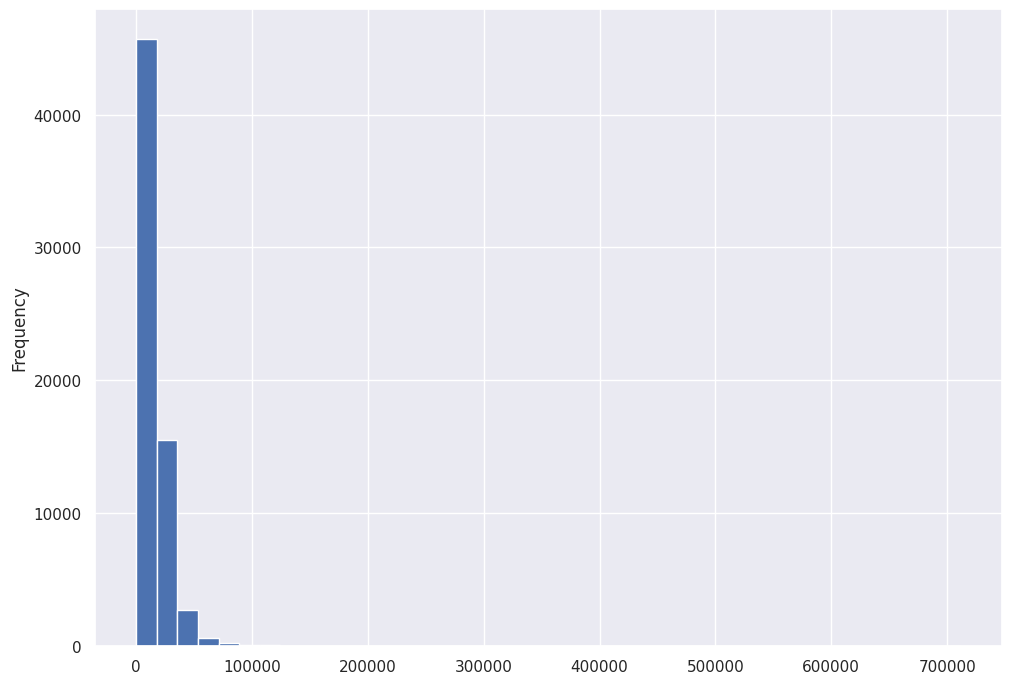

In [45]:
pop_quadras_2022['dens_22'].plot.hist(bins=40)

# Estimativas para 2010

## Calculando as variáveis correspondentes a cada interseção

In [46]:
est_2010 = sim_10.merge(setores10[['CD_GEOCODI', 'pop_total', 'dom_total']])
est_2010.head()

,CD_GEOCODI,cd_identificador_quadra_viaria_editada,geometry,inter_area,inter_perc,pop_total,dom_total
0,355030804000079,22527,"POLYGON ((345097.641 7391483.916, 345091.613 7...",4729.766194,0.159514,554,179
1,355030804000079,22705,"POLYGON ((345079.553 7391426.720, 345073.535 7...",10077.078416,0.339854,554,179
2,355030804000079,27997,"POLYGON ((344978.544 7391258.227, 344973.144 7...",14844.347452,0.500632,554,179
3,355030804000080,22366,"POLYGON ((344925.737 7391505.004, 344935.821 7...",4009.965701,0.131757,713,238
4,355030804000080,22732,"POLYGON ((344886.854 7391409.083, 344881.689 7...",5118.676280,0.168187,713,238


In [47]:
est_2010['pop_total_setor'] = est_2010['pop_total']
est_2010['dom_total_setor'] = est_2010['dom_total']
est_2010['pop_total'] = round(est_2010['pop_total']*est_2010['inter_perc'], 0).astype(int)
est_2010['dom_total'] = round(est_2010['dom_total']*est_2010['inter_perc'], 0).astype(int)
est_2010.head()

,CD_GEOCODI,cd_identificador_quadra_viaria_editada,geometry,inter_area,inter_perc,pop_total,dom_total,pop_total_setor,dom_total_setor
0,355030804000079,22527,"POLYGON ((345097.641 7391483.916, 345091.613 7...",4729.766194,0.159514,88,29,554,179
1,355030804000079,22705,"POLYGON ((345079.553 7391426.720, 345073.535 7...",10077.078416,0.339854,188,61,554,179
2,355030804000079,27997,"POLYGON ((344978.544 7391258.227, 344973.144 7...",14844.347452,0.500632,277,90,554,179
3,355030804000080,22366,"POLYGON ((344925.737 7391505.004, 344935.821 7...",4009.965701,0.131757,94,31,713,238
4,355030804000080,22732,"POLYGON ((344886.854 7391409.083, 344881.689 7...",5118.676280,0.168187,120,40,713,238


## Calculando os erros das estimativas

A estimativa por interpolação baseada na área de interseção assume que os domicílios e a população de cada setor são, em média, uniformemente distribuídos entre todas as áreas de interseção entre os setores censitários e quadras.

Felizmente, podemos calcular o erro possível para cada estimativa caso isso não seja verdade, conforme demonstrado em [Schroeder (2007)](https://onlinelibrary.wiley.com/doi/10.1111/j.1538-4632.2007.00706.x). Em resumo, não existe erro quando um setor inteiro estiver contido dentro da geometria de uma quadra ou nos setores nos quais a quadra não possui relação.

Porém, quando a quadra intersecta parcialmente um setor, existem duas anomalias possíveis: em um extremo, é possível que toda a população daquele setor esteja concentrada exatamente dentro da área de intereseção com a quadra em questão, então nossa estimativa tem viés de subestimação; no outro, pode ser que não existe população na área de intereseção com a quadra, caso no qual nossa estimativa teria viés de superestimação. Assim, o erro da estimação para cada área de interseção é, no mínimo, $-\hat{y}_{sq}$ e, no máximo, $y_{s}-\hat{y}_{sq}$, sendo $\hat{y}_{sq}$ a estimativa de uma dada interseção entre setor censitário e quadra viária e $y_{q}$ a população total de um dado setor censitário.

Finalmente, o mínimo e máximo de erro para cada quadra será o somatório dos mínimos e máximos de cada interseção daquela quadra.

In [48]:
est_2010['pop_total_min'] = est_2010['pop_total']-est_2010['pop_total']*(est_2010['pop_total']!=est_2010['pop_total_setor'])
est_2010['pop_total_max'] = est_2010['pop_total']+est_2010['pop_total_setor']-est_2010['pop_total']
est_2010['dom_total_min'] = est_2010['dom_total']-est_2010['dom_total']*(est_2010['dom_total']!=est_2010['dom_total_setor'])
est_2010['dom_total_max'] = est_2010['dom_total']+est_2010['dom_total_setor']-est_2010['dom_total']
est_2010.head()

,CD_GEOCODI,cd_identificador_quadra_viaria_editada,geometry,inter_area,inter_perc,pop_total,dom_total,pop_total_setor,dom_total_setor,pop_total_min,pop_total_max,dom_total_min,dom_total_max
0,355030804000079,22527,"POLYGON ((345097.641 7391483.916, 345091.613 7...",4729.766194,0.159514,88,29,554,179,0,554,0,179
1,355030804000079,22705,"POLYGON ((345079.553 7391426.720, 345073.535 7...",10077.078416,0.339854,188,61,554,179,0,554,0,179
2,355030804000079,27997,"POLYGON ((344978.544 7391258.227, 344973.144 7...",14844.347452,0.500632,277,90,554,179,0,554,0,179
3,355030804000080,22366,"POLYGON ((344925.737 7391505.004, 344935.821 7...",4009.965701,0.131757,94,31,713,238,0,713,0,238
4,355030804000080,22732,"POLYGON ((344886.854 7391409.083, 344881.689 7...",5118.676280,0.168187,120,40,713,238,0,713,0,238


In [49]:
est_2010[est_2010['pop_total']==est_2010['pop_total_setor']].head()

,CD_GEOCODI,cd_identificador_quadra_viaria_editada,geometry,inter_area,inter_perc,pop_total,dom_total,pop_total_setor,dom_total_setor,pop_total_min,pop_total_max,dom_total_min,dom_total_max
88,355030811000042,47317,"POLYGON ((327753.843 7403292.384, 327753.834 7...",2364.514641,1.000000,549,196,549,196,549,549,196,196
89,355030811000043,47317,"POLYGON ((327869.576 7403275.801, 327869.267 7...",3078.707185,1.000000,709,245,709,245,709,709,245,245
120,355030811000052,48448,"POLYGON ((327110.988 7404561.208, 327104.676 7...",12142.725465,1.000000,501,151,501,151,501,501,151,151
124,355030811000054,63050,"MULTIPOLYGON (((328283.906 7404561.054, 328292...",25169.218315,0.999959,835,219,835,219,835,835,219,219
130,355030811000182,61803,"POLYGON ((328770.584 7405528.364, 328796.072 7...",1556.845102,1.000000,851,273,851,273,851,851,273,273


## Estimando a população por quadra viária

In [50]:
cols = [
    'cd_identificador_quadra_viaria_editada',
    'pop_total',
    'pop_total_min',
    'pop_total_max',
    'dom_total',
    'dom_total_min',
    'dom_total_max',
]
est_2010_agg = est_2010[cols].groupby('cd_identificador_quadra_viaria_editada').sum().reset_index()
est_2010_agg.head()

,cd_identificador_quadra_viaria_editada,pop_total,pop_total_min,pop_total_max,dom_total,dom_total_min,dom_total_max
0,1,94,0,1439,29,0,446
1,21,47,0,535,15,0,172
2,24,48,0,535,15,0,172
3,26,52,0,535,17,0,172
4,28,61,0,535,20,0,172


In [51]:
pop_quadras_2010 = gdf_quadras.merge(est_2010_agg, how='left')
pop_quadras_2010.head()

,geometry,cd_identificador_quadra_viaria_editada,cd_identificador_quadra_viaria_editada_original,tx_tipo_quadra_viaria,tx_escala,tx_ano_referencia,qt_area_metro,sg_fonte_original,pop_total,pop_total_min,pop_total_max,dom_total,dom_total_min,dom_total_max
0,"POLYGON ((338344.482 7407584.661, 338344.543 7...",1,52943,Quadra,1:1.000,2004,7650,SMUL/GEOINFO,94.0,0.0,1439.0,29.0,0.0,446.0
1,"POLYGON ((327186.316 7377154.793, 327188.886 7...",2,4,Praca_Canteiro,1:1.000,2004,11,SMUL/GEOINFO,NaN,NaN,NaN,NaN,NaN,NaN
2,"POLYGON ((324545.386 7402131.104, 324544.170 7...",3,5,Praca_Canteiro,1:1.000,2004,6,SMUL/GEOINFO,NaN,NaN,NaN,NaN,NaN,NaN
3,"POLYGON ((326273.589 7399282.971, 326273.013 7...",4,6,Praca_Canteiro,1:1.000,2004,109,SMUL/GEOINFO,NaN,NaN,NaN,NaN,NaN,NaN
4,"POLYGON ((322149.447 7392535.031, 322154.771 7...",5,7,Praca_Canteiro,1:1.000,2004,12,SMUL/GEOINFO,NaN,NaN,NaN,NaN,NaN,NaN


In [52]:
pop_quadras_2010.loc[:, cols] = pop_quadras_2010.loc[:, cols].fillna(0)
pop_quadras_2010.head()

,geometry,cd_identificador_quadra_viaria_editada,cd_identificador_quadra_viaria_editada_original,tx_tipo_quadra_viaria,tx_escala,tx_ano_referencia,qt_area_metro,sg_fonte_original,pop_total,pop_total_min,pop_total_max,dom_total,dom_total_min,dom_total_max
0,"POLYGON ((338344.482 7407584.661, 338344.543 7...",1,52943,Quadra,1:1.000,2004,7650,SMUL/GEOINFO,94.0,0.0,1439.0,29.0,0.0,446.0
1,"POLYGON ((327186.316 7377154.793, 327188.886 7...",2,4,Praca_Canteiro,1:1.000,2004,11,SMUL/GEOINFO,0.0,0.0,0.0,0.0,0.0,0.0
2,"POLYGON ((324545.386 7402131.104, 324544.170 7...",3,5,Praca_Canteiro,1:1.000,2004,6,SMUL/GEOINFO,0.0,0.0,0.0,0.0,0.0,0.0
3,"POLYGON ((326273.589 7399282.971, 326273.013 7...",4,6,Praca_Canteiro,1:1.000,2004,109,SMUL/GEOINFO,0.0,0.0,0.0,0.0,0.0,0.0
4,"POLYGON ((322149.447 7392535.031, 322154.771 7...",5,7,Praca_Canteiro,1:1.000,2004,12,SMUL/GEOINFO,0.0,0.0,0.0,0.0,0.0,0.0


## Calculando a densidade demográfica por quadra viária

In [53]:
pop_quadras_2010['dens_10'] = pop_quadras_2010['pop_total']/(pop_quadras_2010['qt_area_metro']/1e6)
pop_quadras_2010.loc[pop_quadras_2010['qt_area_metro']==0, 'dens_10'] = 0
pop_quadras_2010

,geometry,cd_identificador_quadra_viaria_editada,cd_identificador_quadra_viaria_editada_original,tx_tipo_quadra_viaria,tx_escala,tx_ano_referencia,qt_area_metro,sg_fonte_original,pop_total,pop_total_min,pop_total_max,dom_total,dom_total_min,dom_total_max,dens_10
0,"POLYGON ((338344.482 7407584.661, 338344.543 7...",1,52943,Quadra,1:1.000,2004,7650,SMUL/GEOINFO,94.0,0.0,1439.0,29.0,0.0,446.0,12287.581699
1,"POLYGON ((327186.316 7377154.793, 327188.886 7...",2,4,Praca_Canteiro,1:1.000,2004,11,SMUL/GEOINFO,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2,"POLYGON ((324545.386 7402131.104, 324544.170 7...",3,5,Praca_Canteiro,1:1.000,2004,6,SMUL/GEOINFO,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
3,"POLYGON ((326273.589 7399282.971, 326273.013 7...",4,6,Praca_Canteiro,1:1.000,2004,109,SMUL/GEOINFO,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
4,"POLYGON ((322149.447 7392535.031, 322154.771 7...",5,7,Praca_Canteiro,1:1.000,2004,12,SMUL/GEOINFO,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64779,"POLYGON ((325071.550 7397335.276, 325073.371 7...",64780,0,Praca_Canteiro,1:1.000,2017,0,SMUL/GEOINFO,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
64780,"POLYGON ((325064.631 7397341.102, 325065.814 7...",64781,0,Praca_Canteiro,1:1.000,2017,0,SMUL/GEOINFO,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
64781,"POLYGON ((325102.327 7397333.002, 325089.121 7...",64782,58914,Praca_Canteiro,1:1.000,2004,25982,SMUL/GEOINFO,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
64782,"POLYGON ((325081.631 7397226.147, 325087.148 7...",64783,0,Praca_Canteiro,1:1.000,2017,0,SMUL/GEOINFO,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


In [54]:
pop_quadras_2010['dens_10'].describe()

count     64784.000000
mean      13007.560517
std       14250.308262
min           0.000000
25%           0.000000
50%       11320.374517
75%       20048.547860
max      529136.163982
Name: dens_10, dtype: float64

<Axes: ylabel='Frequency'>

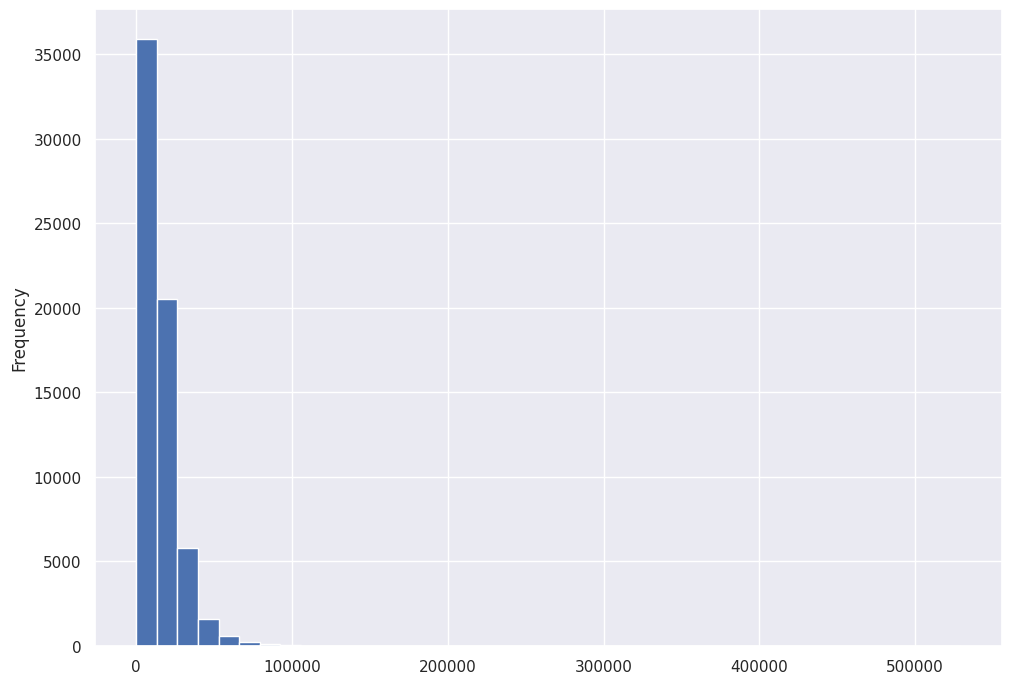

In [55]:
pop_quadras_2010['dens_10'].plot.hist(bins=40)

# Variação na densidade demográfica

In [56]:
quadras_final = pop_quadras_2010.copy()

O inner join entre as duas estimativas deve manter a mesma quantidade de linhas, mas vamos checar o tamanho dos dataframes antes e depois.

In [57]:
pop_quadras_2022.shape

(64784, 15)

In [58]:
pop_quadras_2010.shape

(64784, 15)

In [59]:
quadras_final = quadras_final.rename(columns={'pop_total':'pop_total_prev', 'dom_total':'dom_total_prev'})
quadras_final.head()

,geometry,cd_identificador_quadra_viaria_editada,cd_identificador_quadra_viaria_editada_original,tx_tipo_quadra_viaria,tx_escala,tx_ano_referencia,qt_area_metro,sg_fonte_original,pop_total_prev,pop_total_min,pop_total_max,dom_total_prev,dom_total_min,dom_total_max,dens_10
0,"POLYGON ((338344.482 7407584.661, 338344.543 7...",1,52943,Quadra,1:1.000,2004,7650,SMUL/GEOINFO,94.0,0.0,1439.0,29.0,0.0,446.0,12287.581699
1,"POLYGON ((327186.316 7377154.793, 327188.886 7...",2,4,Praca_Canteiro,1:1.000,2004,11,SMUL/GEOINFO,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2,"POLYGON ((324545.386 7402131.104, 324544.170 7...",3,5,Praca_Canteiro,1:1.000,2004,6,SMUL/GEOINFO,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
3,"POLYGON ((326273.589 7399282.971, 326273.013 7...",4,6,Praca_Canteiro,1:1.000,2004,109,SMUL/GEOINFO,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
4,"POLYGON ((322149.447 7392535.031, 322154.771 7...",5,7,Praca_Canteiro,1:1.000,2004,12,SMUL/GEOINFO,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


In [60]:
quadras_final = quadras_final.merge(pop_quadras_2022[['cd_identificador_quadra_viaria_editada','pop_total','dom_total','dens_22']])
quadras_final.head()

,geometry,cd_identificador_quadra_viaria_editada,cd_identificador_quadra_viaria_editada_original,tx_tipo_quadra_viaria,tx_escala,tx_ano_referencia,qt_area_metro,sg_fonte_original,pop_total_prev,pop_total_min,pop_total_max,dom_total_prev,dom_total_min,dom_total_max,dens_10,pop_total,dom_total,dens_22
0,"POLYGON ((338344.482 7407584.661, 338344.543 7...",1,52943,Quadra,1:1.000,2004,7650,SMUL/GEOINFO,94.0,0.0,1439.0,29.0,0.0,446.0,12287.581699,154.0,55.0,20130.718954
1,"POLYGON ((327186.316 7377154.793, 327188.886 7...",2,4,Praca_Canteiro,1:1.000,2004,11,SMUL/GEOINFO,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
2,"POLYGON ((324545.386 7402131.104, 324544.170 7...",3,5,Praca_Canteiro,1:1.000,2004,6,SMUL/GEOINFO,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
3,"POLYGON ((326273.589 7399282.971, 326273.013 7...",4,6,Praca_Canteiro,1:1.000,2004,109,SMUL/GEOINFO,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
4,"POLYGON ((322149.447 7392535.031, 322154.771 7...",5,7,Praca_Canteiro,1:1.000,2004,12,SMUL/GEOINFO,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000


In [61]:
quadras_final['var_dens'] = quadras_final['dens_22'] - quadras_final['dens_10']
quadras_final

,geometry,cd_identificador_quadra_viaria_editada,cd_identificador_quadra_viaria_editada_original,tx_tipo_quadra_viaria,tx_escala,tx_ano_referencia,qt_area_metro,sg_fonte_original,pop_total_prev,pop_total_min,pop_total_max,dom_total_prev,dom_total_min,dom_total_max,dens_10,pop_total,dom_total,dens_22,var_dens
0,"POLYGON ((338344.482 7407584.661, 338344.543 7...",1,52943,Quadra,1:1.000,2004,7650,SMUL/GEOINFO,94.0,0.0,1439.0,29.0,0.0,446.0,12287.581699,154.0,55.0,20130.718954,7843.137255
1,"POLYGON ((327186.316 7377154.793, 327188.886 7...",2,4,Praca_Canteiro,1:1.000,2004,11,SMUL/GEOINFO,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000
2,"POLYGON ((324545.386 7402131.104, 324544.170 7...",3,5,Praca_Canteiro,1:1.000,2004,6,SMUL/GEOINFO,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000
3,"POLYGON ((326273.589 7399282.971, 326273.013 7...",4,6,Praca_Canteiro,1:1.000,2004,109,SMUL/GEOINFO,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000
4,"POLYGON ((322149.447 7392535.031, 322154.771 7...",5,7,Praca_Canteiro,1:1.000,2004,12,SMUL/GEOINFO,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64779,"POLYGON ((325071.550 7397335.276, 325073.371 7...",64780,0,Praca_Canteiro,1:1.000,2017,0,SMUL/GEOINFO,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000
64780,"POLYGON ((325064.631 7397341.102, 325065.814 7...",64781,0,Praca_Canteiro,1:1.000,2017,0,SMUL/GEOINFO,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000
64781,"POLYGON ((325102.327 7397333.002, 325089.121 7...",64782,58914,Praca_Canteiro,1:1.000,2004,25982,SMUL/GEOINFO,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000
64782,"POLYGON ((325081.631 7397226.147, 325087.148 7...",64783,0,Praca_Canteiro,1:1.000,2017,0,SMUL/GEOINFO,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000


In [62]:
quadras_estimativa_path = 'data/11_estimativa_quadras.parquet'
quadras_final.to_parquet(quadras_estimativa_path)

# Visualizando a estimativa de população e densidade demográfica

In [63]:
def create_map(df:gpd.GeoDataFrame, col_mapper:dict, legend_column:str, base:str='2022', **kwargs) -> folium.Map:
    
    df = df[[k for k in col_mapper]].copy()
    # df = df[df['pop_total'].astype(int) > 0]
    df = df.rename(columns=col_mapper)
    if base == '2022':
        # m = setores10[['CD_GEOCODI', 'pop_total', 'geometry']].explore(
        #     tiles="CartoDB positron",  # use "CartoDB positron" tiles
        #     name='Setores censitários (2010)',
        #     color='grey',
        #     style_kwds={'fillOpacity': 0.1},
        # )
        
        # m = est_2010[['CD_SETOR', 'CD_GEOCODI', 'pop_total', 'geometry']].explore(
        #     m=m,
        #     name='Similaridades',
        #     color='grey',
        #     style_kwds={'fillOpacity': 0.1},
        #     show=False,
        # )
        
        m = setores22[['CD_SETOR', 'pop_total', 'geometry']].explore(
            tiles="CartoDB positron",  # use "CartoDB positron" tiles
            name='Setores censitários (2022)',
            color='grey',
            style_kwds={'fillOpacity': 0.1},
        )
    
        m = setores22[['geometry']].dissolve().explore(
            m=m,
            name='Limite municipal',
            color='black',
            style_kwds={'fill': False},
        )
    elif base == '2010':
        m = setores22[['CD_SETOR', 'pop_total', 'geometry']].explore(
            tiles="CartoDB positron",  # use "CartoDB positron" tiles
            name='Setores censitários (2022)',
            color='grey',
            style_kwds={'fillOpacity': 0.1},
        )
        
        m = est_2022[['CD_GEOCODI', 'CD_SETOR', 'pop_total', 'geometry']].explore(
            m=m,
            name='Similaridades',
            color='grey',
            style_kwds={'fillOpacity': 0.1},
            show=False,
        )
    
        m = setores10[['geometry']].dissolve().explore(
            m=m,
            name='Limite municipal',
            color='black',
            style_kwds={'fill': False},
        )

    defaultKwargs = {
        # 'scheme': 'quantiles',
        'cmap': 'coolwarm',
        # 'k': 10,
        'legend_kwds': {'colorbar': True}
    }
    kwargs = { **defaultKwargs, **kwargs }

    popup_cols = [
        # 'Setor censitário',
        # 'Distrito',
        'População total (2010)',
        'População total (2022)',
        # 'Variação populacional (absoluta)',
        # 'Variação populacional (%)',
        'Densidade demográfica - 2022 (hab/km^2)',
        'Densidade demográfica - 2010 (hab/km^2)',
        'Variação na densidade demográfica (hab/km^2)',
        # 'Variação na densidade demográfica normalizada (raiz cúbica)',
    ]
        
    m = df.explore(
        m=m,
        column=legend_column,  # make choropleth based on "POP2010" column
        legend=True,  # show legend
        tooltip=popup_cols,
        popup=popup_cols,
        # legend_kwds=dict(colorbar=True, scale=False),  # do not use colorbar
        # legend_kwds=dict(colorbar=True),  # do not use colorbar
        name=legend_column,  # name of the layer in the map,
        **kwargs
    )
    
    folium.LayerControl().add_to(m)

    folium_plugins.Fullscreen(
        position='topright',
        title='Tela cheia',
        title_cancel='Exit me',
        force_separate_button=True,
    ).add_to(m)

    return m

In [64]:
mapper_final = {
    'cd_identificador_quadra_viaria_editada': 'Quadra viária',
    'pop_total': 'População total (2022)',
    'pop_total_prev': 'População total (2010)',
    # 'var_pop': 'Variação populacional (absoluta)',
    # 'var_pop_perc': 'Variação populacional (percentual)',
    # 'var_pop_perc_str': 'Variação populacional (%)',
    'var_dens': 'Variação na densidade demográfica (hab/km^2)',
    # 'cbrt_var_dens': 'Variação na densidade demográfica normalizada (raiz cúbica)',
    'dens_22': 'Densidade demográfica - 2022 (hab/km^2)',
    'dens_10': 'Densidade demográfica - 2010 (hab/km^2)',
    'geometry': 'geometry'
}

In [65]:
%%time
m = create_map(quadras_final, mapper_final, 'Densidade demográfica - 2022 (hab/km^2)', cmap='Reds')

CPU times: user 20.3 s, sys: 677 ms, total: 21 s
Wall time: 21.2 s


In [66]:
%%time
m.save('plots/Densidade demográfica - Quadras viárias.html')

CPU times: user 33.1 s, sys: 2.7 s, total: 35.8 s
Wall time: 50.7 s


In [67]:
%%time
m = create_map(
    quadras_final,
    mapper_final,
    'Densidade demográfica - 2022 (hab/km^2)',
    scheme='quantiles',
    k=10,
    legend_kwds={'colorbar': False},
    cmap='Reds',
)

/home/d855395/git/compatibilizacao-setores-censitarios/env/lib/python3.12/site-packages/mapclassify/classifiers.py:1592: UserWarning: Not enough unique values in array to form 10 classes. Setting k to 9.
  self.bins = quantile(y, k=k)


CPU times: user 21 s, sys: 605 ms, total: 21.6 s
Wall time: 31.3 s


In [68]:
%%time
m.save('plots/Densidade demográfica - Quadras viárias - categorias.html')

CPU times: user 34.6 s, sys: 3.22 s, total: 37.8 s
Wall time: 54.4 s


In [69]:
%%time
m = create_map(
    quadras_final,
    mapper_final,
    'Variação na densidade demográfica (hab/km^2)',
    scheme='quantiles',
    k=10,
    legend_kwds={'colorbar': False},
)

/home/d855395/git/compatibilizacao-setores-censitarios/env/lib/python3.12/site-packages/mapclassify/classifiers.py:1592: UserWarning: Not enough unique values in array to form 10 classes. Setting k to 8.
  self.bins = quantile(y, k=k)


CPU times: user 22.2 s, sys: 568 ms, total: 22.7 s
Wall time: 28.2 s


In [70]:
%%time
m.save('plots/Variação na densidade demográfica - Quadras viárias.html')

CPU times: user 33 s, sys: 1.78 s, total: 34.8 s
Wall time: 36.8 s
